In [1]:
!TF_GPU_HOST_MEM_LIMIT_IN_MB=256000
!export TF_GPU_HOST_MEM_LIMIT_IN_MB

In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import jax.random as jr
import tensorflow_probability as tfp
from jax import numpy as jnp, random as jr
from sbijax import NPE
from sbijax.nn import make_maf, make_mdn
from tensorflow_probability.substrates.jax import distributions as tfd

from sbijax import plot_posterior, plot_trace, plot_rank, plot_rhat_and_ress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import matplotlib as mpl
mpl.rcParams.update({"text.usetex": False,
                     })#mpl.rcParamsDefault)

mpl.rcParams.update(mpl.rcParamsDefault)


gpu


2025-01-26 23:12:31.050037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 23:12:31.050114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 23:12:31.087170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 23:12:42.747580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cd /home/makinen/repositories/des-hybrid/

/home/makinen/repositories/des-hybrid


/home/makinen/venvs/epe/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp
import math
from network.NPE import npe
from network.NPE.multipole_cnn import MultipoleConv
from network.NPE.multipole_cnn_factory import MultipoleCNNFactory
import cloudpickle as pickle

Array = Any
import numpy as np

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *
from network.epe_code import *

import numpy as np


gpu_device = jax.devices('gpu')[0]
cpu_device = jax.devices('cpu')[0]

cls_stats_file = jnp.load("/home/makinen/repositories/des-hybrid/cls_utils/cls_statistics_for_normalisation.npz")
S1_cls=cls_stats_file["S1_cls"]
S2_cls=cls_stats_file["S2_cls"]
mean_cl=cls_stats_file["mean_cl"]
std_cl=cls_stats_file["std_cl"]
cut_idx=cls_stats_file["cut_idx"]

def slice_cls(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, :, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

def slice_cls_single(cls):
    cls = (cls - mean_cl) / std_cl
    cls = cls[:, 0, 0::3, :cut_idx]
    return cls.reshape(cls.shape[0], -1)

# define model

class MLP(nn.Module):
  features: Sequence[int]
  act: Callable = nn.relu

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

class MLPNetwork(nn.Module):
    hidden_channels: list
    n_p: int
    act: Callable = nn.relu
    sigmoid_out: bool = False

    def setup(self):
        self.embed = nn.Dense(450)
        self.embed2 = nn.Dense(500)
        #self.layernorm = nn.LayerNorm()
        self.net = MLP(self.hidden_channels + (self.n_p,), act=self.act)

    def __call__(self, x, mask=None):

        # cut down mass value
        x = slice_cls_single(x)
        x = x.reshape(-1)
        x = self.embed(x)
        #x = self.layernorm(x)
        x = self.embed2(x)
        x = self.act(x)
        x = self.net(x)

        if self.sigmoid_out:
            x = nn.sigmoid(x)

        return x


key = jax.random.PRNGKey(0) # pseudo-random key for Jax network.
cls_model = MLPNetwork(
                        hidden_channels=[256]*10,
                        n_p=3,
                        act=nn.relu,
                        sigmoid_out=True
                        
)

cls_single_shape = (10, 2, 4, 28,)
w_cls_compress = load_obj("/home/makinen/repositories/des-hybrid/vanilla-comparison/w_cls_compress_relu_13_01.pkl")
cls_compression = lambda d: cls_model.apply(w_cls_compress, d)

# put Cls compression onto the cpu
cls_compression = jax.jit(cls_compression, device=cpu_device)

2025-01-26 23:19:39.278792: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp
import math
from network.NPE import npe
from network.NPE.multipole_cnn import MultipoleConv
from network.NPE.multipole_cnn_factory import MultipoleCNNFactory
import cloudpickle as pickle

Array = Any
import numpy as np

from network.cls_utils import *
# from network.moped_auto import *
# from network.moped import *
from network.net_utils import *
from network.epe_code import *

import numpy as np


class simpleCNN(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    cls_compression: Callable
    n_extra: int = 3
    act_cnn: Callable = nn.relu
    act_dense: Callable = nn.swish
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):

        filters = self.filters
        # add in Cls information
        cls_summs = x["cls"]
        cls_summs = self.cls_compression(cls_summs)
        
        x = x["kappa"][jnp.newaxis, ...]

        x = x.astype(self.dtype)
        for i in range(8):
            x = nn.Conv(features=filters, kernel_size=(3,3), strides=(1,1), padding="SAME", dtype=self.dtype)(x)
            x = self.act_cnn(x)
            x = nn.avg_pool(x, (2,2), strides=(2,2))

        #print("x", x.shape)
        # mean pool out
        x = x.reshape(-1)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)

        # add in layernorm here ??
        #x = nn.LayerNorm()(x)
        
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        #x *= 10.
        x = jnp.concatenate([cls_summs.reshape(-1), x])
        return nn.LayerNorm()(x)


# initialise mpk model
model_key = jr.key(44)

patch_A_net = simpleCNN(
                filters=32,
                cls_compression=cls_compression,
                act_cnn=nn.relu,
                act_dense=nn.leaky_relu,
                n_extra=3,
                dtype=jnp.float32,
)

# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----

mdn_hidden = (70,70)
n_components = 4 
modelA = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, 
                                embedding_net=patch_A_net,
                               hidden_sizes=mdn_hidden))

# load weights from pretraining
w_patch_A = load_obj("/home/makinen/repositories/des-hybrid/vanilla-comparison/w_patchA_vanilla_net_default.pkl")

def apply_embedding_A(input_data, w=w_patch_A):
    return modelA.model.apply(w, x=input_data, rng=jr.PRNGKey(400), method='embedding')


#apply_embedding_A = tf.py_function(Tout=tf.float32)(apply_embedding_A)

## dataset assembly

In [5]:
import glob
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds


base_path = "/data103/makinen/des_sims/Gower_street_SBI_tfrecords/"
patch = "A"
use_noise_realisations =['0','1','2','3','10', '11', '12']#,'11','12','13','14','15']
cls_stats_file = jnp.load("/home/makinen/repositories/des-hybrid/cls_utils/cls_statistics_for_normalisation.npz")
S1_cls=cls_stats_file["S1_cls"]
S2_cls=cls_stats_file["S2_cls"]
mean_cl=cls_stats_file["mean_cl"]
std_cl=cls_stats_file["std_cl"]
cut_idx=cls_stats_file["cut_idx"]


def gaussian_noise_augmentation(x, y, cls, param_idx=None):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-3,
                        dtype = tf.float32
                        ) #Mask option?

    # add noise to cls
    cls += tf.random.normal(
                shape = [10, 2, 4, 28],
                mean = 0, 
                stddev =std_cl*1e-3,
                dtype = tf.float32
                )

    if param_idx is not None:
        y = tf.expand_dims(y[param_idx], 0)

    # data is now a dictionary
    return {"y": {"kappa": x, "cls": cls}, "theta": y}

def compress_patch_A(data, param_idx=None):
    x = apply_embedding_A(data)
    return {"y": {"summaries": x}, "theta": y}
    


def compress_patch_A(x, y, cls, param_idx=None):
    x += tf.random.normal(
                        shape = [512, 512,8],
                        mean = 0,
                        stddev = 1e-3,
                        dtype = tf.float32
                        ) #Mask option?

    # add noise to cls
    cls += tf.random.normal(
                shape = [10, 2, 4, 28],
                mean = 0, 
                stddev =std_cl*1e-3,
                dtype = tf.float32
                )

    if param_idx is not None:
        y = tf.expand_dims(y[param_idx], 0)

    #data = {"y": {"kappa": x, "cls": cls}, "theta": y}
    #data = (cls, x)

    print(cls.shape)
    
    x = m.predict(x, cls)
    return {"y": {"summaries": x}, "theta": y}





def ret_scaled_param(data,param):
    s = 0.6
    if param == 'AIA':
        hi = 3
        lo = -3

    if param == "s8":
        hi = 1.32
        lo = 0.4

    if param == 'om':
        hi = 0.5
        lo = 0.13

    if param == "h":
        hi = 0.6
        lo = 0.8

    if param == 'w':
        hi = -0.33
        lo = -1.8
    if param == "ns":
        hi = 0.99
        lo = 0.94
    if param == 'ob':
        hi = 0.061
        lo = 0.037


    return (data[param] -lo)*s/(hi - lo) + (1 - s)*0.5

def param_proc(data, scale_params=True):
    Y = []
    for p in sel_params:
        # scale params if so desired
        if scale_params:
            if p=="S8":
                Y.append(data["s8"]*tf.math.sqrt(data["om"]/0.3)-0.25)
            else:
                Y.append(ret_scaled_param(data, p))
                
        # else just return the param
        else:
            Y.append(data[p])
            
    Y = tf.convert_to_tensor( Y , dtype = tf.float32)
    return Y

def cls_proc(data):
    Cls = []
    for c in cl_modes:

        cls = tf.io.parse_tensor(data[c], out_type=tf.float32)
        cls = tf.cast(cls, tf.float32)
        
        Cls.append(cls)
    
    return Cls #tf.convert_to_tensor(Cls, dtype=tf.float32)


def return_train_test_lists(patch):
    files = glob.glob(base_path + "{}/".format(patch) +"shear_maps_*")
    print(base_path + "{}/".format(patch) +"shear_maps_*")

    # sort the files to match A to B to C !
    files.sort(key=lambda x:[int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)])

    
    print(len(files))
    train_file_list = []
    test_file_list = []
    lfi_file_list = []
    test_file_systematic_list = []
    for file in files:
        noiserel = file.split("_rel")[0].split('noiserel')[-1]
        if noiserel in use_noise_realisations:
            if noiserel == '3':
                test_file_list.append(file)
            elif noiserel == '10':
                lfi_file_list.append(file)
            elif noiserel == '12':
                test_file_systematic_list.append(file)
            else:
                train_file_list.append(file)
    return train_file_list, test_file_list, lfi_file_list, test_file_systematic_list

def parse_serialized_file(cereal_yum, scale_params=True, filter_w=True):

    features = {
            "kappa_patch":  tf.io.FixedLenFeature([], tf.string),
            #"CLS":  tf.io.FixedLenFeature([], tf.float32, default_value=0.0),

            # load the cls values
            "1_1": tf.io.FixedLenFeature([], tf.string),
            "1_2": tf.io.FixedLenFeature([], tf.string),
            "1_3": tf.io.FixedLenFeature([], tf.string),
            "1_4": tf.io.FixedLenFeature([], tf.string),
            "2_2": tf.io.FixedLenFeature([], tf.string),
            "2_3": tf.io.FixedLenFeature([], tf.string),
            "2_4": tf.io.FixedLenFeature([], tf.string),
            "3_3": tf.io.FixedLenFeature([], tf.string),
            "3_4": tf.io.FixedLenFeature([], tf.string),
            "4_4": tf.io.FixedLenFeature([], tf.string),

            # load parameters
            "s8": tf.io.FixedLenFeature([], tf.float32),
            "om": tf.io.FixedLenFeature([], tf.float32),
            "AIA": tf.io.FixedLenFeature([], tf.float32),
            "w": tf.io.FixedLenFeature([], tf.float32)
    }

    data = tf.io.parse_single_example(cereal_yum, features)


    # else:
    # proceed as usual to get everything
    Y = param_proc(data, scale_params=scale_params)
    CLS_DS = cls_proc(data)

    X_DS = tf.io.parse_tensor(data["kappa_patch"], out_type=tf.float32)
    X_DS = tf.cast(X_DS, tf.float32)
    X_DS = tf.reshape(X_DS, shape=(8,512,512))
    X_DS = tf.transpose(X_DS, perm = [1,2,0])
    
    return X_DS,Y,CLS_DS





with tf.device("CPU"):
    sel_params = ["om","s8","w"]
    cl_modes = ["1_1","1_2","1_3","1_4","2_2","2_3","2_4","3_3","3_4", "4_4"]
    BATCH_SIZE = 64
    EPOCHS = 1000 # max epochs
    n_readers=1
    try:
        del train_dataset
        del test_dataset
        gc.collect()
    except:
        pass        

    # smarter way to collect files ?
    train_files, test_files, lfi_files, test_sys_files = return_train_test_lists('{}'.format("A"))
    train_files_B, test_files_B, lfi_files_B, test_sys_files_B = return_train_test_lists('{}'.format("B"))

    # check to see if files are mismatched
    for i,t in enumerate(train_files):
        if t[55:] == train_files_B[i][55:]:
            pass
        else:
            print("alert ! file mismatch")

    SHUFFLE_BUFFER_SIZE = 100
    
    #train_files, test_files, lfi_files, test_sys_files = return_train_test_lists('{}'.format(patch))
    num_train_files = len(train_files)
    num_test_files = len(test_files)
    num_lfi_files = len(lfi_files)
    num_sys_files = len(test_sys_files)

    print("train files: ", num_train_files, "test files: ", num_test_files, "lfi files: ", num_lfi_files, "test sys files: ", num_sys_files,)


    # ----- dataset code -----
    def get_tfdataset(files, 
                          batch_size=64, 
                          epochs=1000,
                          scale_params=True, 
                          param_idx=None,
                          to_numpy=True,
                          shuffle=True,
                          compress_A=False,
                          shuffle_buffer_size=100,
                          drop_remainder=True):
        
        num_files = len(files)
        print("num files: ", num_files)
        tfdataset = tf.data.Dataset.from_tensor_slices(files)
    
        if param_idx is not None:
            print("retrieving parameter %d"%(param_idx))
        
        tfdataset = tfdataset.interleave(
            tf.data.TFRecordDataset,
            cycle_length=n_readers,
            block_length=1,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )
    
        tfdataset = tfdataset.map(
            lambda serialized_example: parse_serialized_file(
                serialized_example,
                scale_params=scale_params    
            ),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        # control shuffle to keep interleaved datasets matched up
        if shuffle:
            tfdataset = tfdataset.shuffle(shuffle_buffer_size)

        if compress_A:
            tfdataset = tfdataset.map(lambda maps,vals,cls: \
                                  compress_patch_A(maps,vals,cls,param_idx=param_idx),\
                                  num_parallel_calls=tf.data.AUTOTUNE)
        
        else:
            tfdataset = tfdataset.map(lambda maps,vals,cls: \
                                  gaussian_noise_augmentation(maps,vals,cls,param_idx=param_idx),\
                                  num_parallel_calls=tf.data.AUTOTUNE)
            
        #tfdataset = tfdataset.batch(batch_size, drop_remainder=drop_remainder).prefetch(tf.data.AUTOTUNE) 
        #tfdataset = tfdataset.repeat(epochs)
        
    
        if to_numpy:
            tfdataset = tfdataset.as_numpy_iterator()
            tfdataset.num_batch_per_epoch = num_files // batch_size
            tfdataset.num_samples = (num_files // batch_size) * batch_size
    
    
        return tfdataset
    
    # is it better to consolidate the data in one dictionary or just pass a tuple to the network ?
    
    # stack A and B patches
    #train_dataset = tf.data.Dataset.zip((train_dataset,train_datasetB))
    
    def consolidate_dsets(A,B,C=None):
        # check that cosmo params are the same    
        if C is not None:
            return {"y": {"A": {"kappa": A["y"]["kappa"], "cls": A["y"]["cls"]},
                          "B": {"kappa": B["y"]["kappa"], "cls": B["y"]["cls"]},
                          "C": {"kappa": C["y"]["kappa"], "cls": C["y"]["cls"]}
                         },
                    "theta": A["theta"], 
                    "theta_A": A["theta"], 
                    "theta_B":B["theta"],  
                    "theta_C":C["theta"],
            }
        else:
            return {"y": {"A": {"summaries": A[0], 
                                "theta_A": A[1]
                               },
                  "B": {"kappa": B["y"]["kappa"], 
                        "cls": B["y"]["cls"]},
                 },
                "theta":B["theta"],  
                   }
    
    # train_dataset = train_dataset.map(lambda A,B: consolidate_dsets(A,B))

    # LOAD IN SUMMARIES FROM PATCH A, ORDERED ACCORDINGLY

    
    
    def stack_tfdatasets(summaries_A, params_A,
                         files_B, files_C=None, 
                         epochs=1000,
                          batch_size=64, scale_params=True, to_numpy=True, shuffle=True,
                         shuffle_buffer_size=100, drop_remainder=True):
    
        num_files_A = len(summaries_A)
        num_files_B = len(files_B)
        # if num_files_A != num_files_B:
        #     raise Exception("number of files for patch A (%d) doesn't \n \
        #                             match number of files for patch B (%d)"%(num_files_A, num_files_B))
        
        
        tfdataset_A = tf.data.Dataset.from_tensor_slices((summaries_A, params_A)) # we probably don't need the params here
    
        tfdataset_B = get_tfdataset(files_B, batch_size=batch_size, scale_params=scale_params, 
                                    to_numpy=False, shuffle=False, 
                                    shuffle_buffer_size=shuffle_buffer_size, 
                                    drop_remainder=drop_remainder)
    
        if files_C is not None:
            tfdataset_C = get_tfdataset(files_C, batch_size=batch_size, scale_params=True, 
                                to_numpy=False, shuffle=False, 
                                shuffle_buffer_size=shuffle_buffer_size, 
                                drop_remainder=drop_remainder)
            # zip all three
            tfdataset =  tf.data.Dataset.zip((tfdataset_A,tfdataset_B,tfdataset_C))
            tfdataset = tfdataset.map(lambda A,B,C: consolidate_dsets(A,B,C), num_parallel_calls=tf.data.AUTOTUNE,)
            
        else:
            # compress and cache dataset A
            #tfdataset_A = tfdataset_A.map(lambda d: compress_patch_A(d), num_parallel_calls=tf.data.AUTOTUNE).cache()
            #tfdataset_A = tfdataset_A.
            
            # just zip two datasets
            tfdataset =  tf.data.Dataset.zip((tfdataset_A,tfdataset_B))

            # do we need interleave here again ?
            # tfdataset = tfdataset.interleave(
            #         tf.data.TFRecordDataset,
            #         cycle_length=n_readers,
            #         block_length=1,
            #         num_parallel_calls=tf.data.AUTOTUNE,
            #         deterministic=True,
            #     )
            
            # now map the dictionary function to get in the right format for mdn
            tfdataset = tfdataset.map(lambda A,B: consolidate_dsets(A,B), num_parallel_calls=tf.data.AUTOTUNE,) 

        
        # THEN shuffle
        if shuffle:
            tfdataset = tfdataset.shuffle(shuffle_buffer_size)

        # batch here
        tfdataset = tfdataset.batch(batch_size, drop_remainder=drop_remainder) #.prefetch(tf.data.AUTOTUNE) 

        # repeat dataset
        tfdataset = tfdataset.repeat(epochs)
    
    
        if to_numpy:
            tfdataset = tfdataset.as_numpy_iterator()
            tfdataset.num_batch_per_epoch = num_files_A // batch_size
            tfdataset.num_samples = (num_files_A // batch_size) * batch_size
    
    
        return tfdataset
    # ----- dataset code -----

    # LOAD IN SUMMARIES FROM PATCH A
     # summaries_lfi=np.concatenate(summaries_LFI, 0),
     # params_lfi=np.concatenate(params_Tru_LFI, 0),
     # summaries_test=np.concatenate(summaries_test,0),
     # params_test=np.concatenate(params_Tru_test,0),
     # summaries_sys=np.concatenate(summaries_sys,0),
     # params_sys=np.concatenate(params_Tru_sys,0),
     # summaries_train=np.concatenate(summaries_train,0),
     # params_train=np.concatenate(params_Tru_train,0),
     # # save file lists as well
     # train_files=train_files,
     # test_files=test_files,
     # lfi_files=lfi_files,
     # sys_files=test_sys_files
     # )

    summaries_A_file = np.load("/data103/makinen/des_results/patch_nets/summaries_default_patchA.npz")

    # train, test validation datasets
    train_dataset = stack_tfdatasets(summaries_A_file["summaries_train"], summaries_A_file["params_train"],
                                        train_files_B, batch_size=BATCH_SIZE, scale_params=True, to_numpy=True)
    
    test_dataset = stack_tfdatasets(summaries_A_file["summaries_test"], summaries_A_file["params_test"],
                test_files_B, batch_size=BATCH_SIZE, scale_params=True, to_numpy=True, drop_remainder=False)

    
    lfi_dataset = stack_tfdatasets(summaries_A_file["summaries_lfi"], summaries_A_file["params_lfi"],
                lfi_files_B, batch_size=BATCH_SIZE, scale_params=False, to_numpy=True, epochs=3)
    
    sys_dataset = stack_tfdatasets(summaries_A_file["summaries_sys"], summaries_A_file["params_sys"],
                test_sys_files_B, batch_size=BATCH_SIZE, scale_params=False, to_numpy=True, epochs=3)
    

/data103/makinen/des_sims/Gower_street_SBI_tfrecords/A/shear_maps_*
30880
/data103/makinen/des_sims/Gower_street_SBI_tfrecords/B/shear_maps_*
30880
train files:  12352 test files:  3088 lfi files:  3088 test sys files:  3088
num files:  12352
num files:  3088
num files:  3088
num files:  3088


In [27]:
summaries_A_file["summaries_test"].shape

(3072, 6)

In [6]:
summaries_A_file["summaries_train"].shape

(12352, 6)

In [35]:
data = next(iter(test_dataset))

In [6]:
data = next(iter(train_dataset))

In [38]:
from tqdm import tqdm
for i in tqdm(range(test_dataset.num_batch_per_epoch)):
    data = next(iter(test_dataset))
    print((data['y']['A']['theta_A'] == data['theta'])[0][0])

 19%|█▉        | 9/48 [00:00<00:00, 86.82it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


 38%|███▊      | 18/48 [00:01<00:03,  8.37it/s]

True
True
True


 46%|████▌     | 22/48 [00:02<00:03,  7.13it/s]

True
True
True
True


 52%|█████▏    | 25/48 [00:03<00:03,  6.53it/s]

True


 56%|█████▋    | 27/48 [00:03<00:03,  6.21it/s]

True
True


 60%|██████    | 29/48 [00:04<00:03,  5.92it/s]

True
True


 62%|██████▎   | 30/48 [00:04<00:03,  5.84it/s]

True


 67%|██████▋   | 32/48 [00:04<00:02,  5.54it/s]

True
True


 71%|███████   | 34/48 [00:05<00:02,  5.33it/s]

True
True


 75%|███████▌  | 36/48 [00:05<00:02,  5.23it/s]

True
True


 77%|███████▋  | 37/48 [00:05<00:02,  5.17it/s]

True


 81%|████████▏ | 39/48 [00:06<00:01,  5.13it/s]

True
True


 85%|████████▌ | 41/48 [00:06<00:01,  5.18it/s]

True
True


 88%|████████▊ | 42/48 [00:06<00:01,  5.06it/s]

True


 92%|█████████▏| 44/48 [00:06<00:00,  5.12it/s]

True
True


 96%|█████████▌| 46/48 [00:07<00:00,  5.09it/s]

True
True


100%|██████████| 48/48 [00:07<00:00,  6.16it/s]

True
True


In [21]:
data['y']['A']['summaries'].shape, data['y']['B']['kappa'].shape

((64, 6), (64, 512, 512, 8))

In [ ]:
data = next(iter(train_dataset))

In [ ]:
data['y']['A']['kappa']

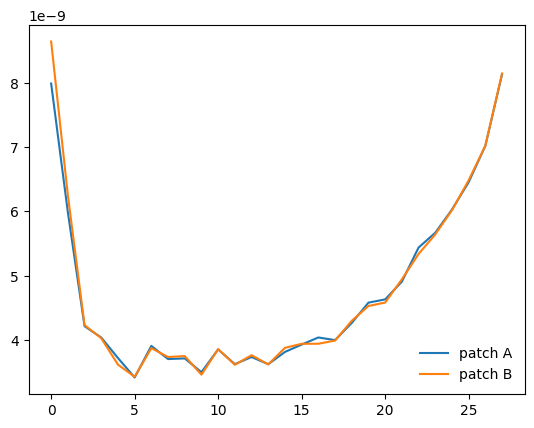

In [7]:
plt.plot(data['y']['A']['cls'][0, 0, 0, 0, ], label='patch A')
plt.plot(data['y']['B']['cls'][0, 0, 0, 0, ], label='patch B')
plt.legend(framealpha=0)
plt.show()

In [6]:
#@title config code
import sys,os
import yaml
import jax_cosmo as jc

from network.cls_utils import *
from network.net_utils import *
from network.epe_code import *


import sys,os
import yaml
import numpy as np
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


# -----
# folder to load config file
CONFIG_PATH = "./network/"

config_name = "config_default.yaml"
noiseamp = 0.125

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

config = load_config(config_name)
# -----

num_tomo = 4
indices = jnp.array(indices_vector(config["num_tomo"]))
# define the mpk layer before initialising network
dtype = jnp.float32 # jnp.bfloat16
kernel_size = config["mpk_kernel"]
polynomial_degrees = config["polynomial_degrees"]
mpk_layer = MultipoleCNNFactory(
            kernel_shape=(kernel_size, kernel_size),
            polynomial_degrees=polynomial_degrees,
            output_filters=None,
            dtype=dtype)



In [107]:
class simpleCNN_B(nn.Module):
    """An incept-stride net architecture with MultiPole Kernel (MPK) embedding"""
    filters: Sequence[int]
    #existing_compression: Callable
    n_extra: int = 3
    n_existing: int = 3
    act_cnn: Callable = nn.relu
    act_dense: Callable = nn.swish
    dtype: Any = jnp.float32


    @nn.compact
    def __call__(self, x):

        # idea: apply Cls compression to both Cls noise realisations and then average together ?

        # unpack data
        inputs = x
        
        # work around the dumb vmap bit
        #patch_A_inputs = {"kappa": inputs["A"]["kappa"][jnp.newaxis, ...], "cls": inputs["A"]["cls"][jnp.newaxis, ...]}
        #existing_info = self.existing_compression(jax.lax.stop_gradient(patch_A_inputs))

        existing_info = inputs["A"]["summaries"].reshape(-1)
        
        # first just take first four filters (E modes !)
        x = inputs["B"]["kappa"]
        x = x.astype(self.dtype)

        filters = self.filters
        
        for i in range(8):
            x = nn.Conv(features=filters, kernel_size=(3,3), strides=(1,1), padding="SAME", dtype=self.dtype)(x)
            x = self.act_cnn(x)
            x = nn.avg_pool(x, (2,2), strides=(2,2))

        #print("x", x.shape)
        # mean pool out
        x = x.reshape(-1)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(20)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(10)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)
        x = nn.Dense(5)(x)
        x = self.act_dense(x)

        # add in layernorm here ??
        #x = nn.LayerNorm()(x)
        
        # x = nn.Dense(self.n_extra + self.n_existing, dtype=self.dtype)(x).reshape(-1)
        # x = x.reshape(-1).astype(jnp.float32) # make sure output is float32
        # add information to the other extra numbers
        # x = x.at[:self.n_existing].set((x[:self.n_existing] + existing_info[3:self.n_existing + self.n_extra]) / 2.)
        # x = jnp.concatenate([existing_info[:self.n_extra], x])

        # x += existing_info[self.n_extra:]
        # x /= 2.

        # vanilla code
        x = nn.Dense(self.n_extra, dtype=self.dtype)(x).reshape(-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32
        
        x = jnp.concatenate([existing_info.reshape(-1), x])
        x = nn.LayerNorm()(x)
        return x #nn.LayerNorm()(x)
        

In [116]:
patch_B_net = simpleCNN_B(
                filters=32,
                #existing_compression=apply_embedding_A,
                act_cnn=nn.relu,
                act_dense=nn.leaky_relu,
                n_extra=5,
                n_existing=3,
                dtype=jnp.float32,
)

In [109]:
data = next(iter(train_dataset))

wembed = patch_B_net.init(model_key, {"A":{"summaries": jnp.ones((6)),
                                      "cls": jnp.ones((10,2,4,28))},
                                      "B":{"kappa": jnp.ones((512,512,8)),
                                      "cls": jnp.ones((10,2,4,28))}
                                     })

In [110]:
appl = lambda d: patch_B_net.apply(wembed, d)

outs = jax.vmap(appl)(data['y'])

outs.shape

(64, 9)

In [111]:
outs[6]

Array([ 0.673418  , -0.35030758,  0.51788616, -0.29403567,  1.7028317 ,
       -2.2736077 ,  0.00793859,  0.00793868,  0.00793776], dtype=float32)

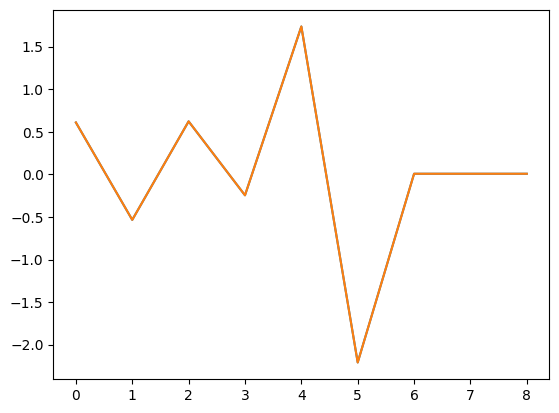

In [112]:
plt.plot(outs[0, :])
plt.plot(outs[0, :])
plt.show()

In [84]:
epochs = 200

In [83]:
train_dataset.num_batch_per_epoch

193

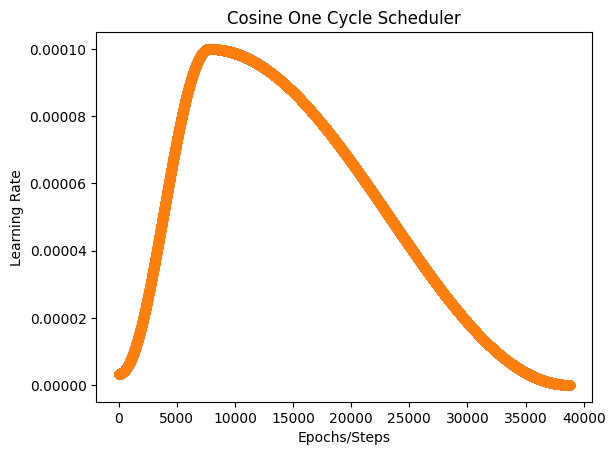

In [86]:
total_steps = epochs*(train_dataset.num_batch_per_epoch) + epochs
cosine_onecycle_scheduler = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.0001,
                                                           pct_start=0.20, div_factor=30., final_div_factor=100.)

lrs = [cosine_onecycle_scheduler(i) for i in range(total_steps)]

plt.scatter(range(total_steps), lrs)
plt.title("Cosine One Cycle Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [ ]:
# ---- DUMMY FUNCTIONS ----
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Uniform(low=jnp.array([-2, 0.1]), high=jnp.array([2, 10.0]))
    ), batch_ndims=0)
    return prior

def simulator_fn(seed, theta, n_d=50):
    #print("theta", theta["theta"].shape)
    theta = theta["theta"]
    p = tfd.Normal(jnp.zeros((theta.shape[0], n_d)), 1.0)
    noise =  p.sample(seed=seed) * jnp.sqrt(theta[..., 1, jnp.newaxis])
    y = theta[..., 0, jnp.newaxis] + noise
    return y

fns = prior_fn, simulator_fn # remove this dependency
# ---- DUMMY FUNCTIONS ----


mdn_hidden = (70,70)
n_components = 4 # 2 not so good


model = myNPE(fns, my_make_mdn(n_dimension=3,
                               n_components=n_components, embedding_net=patch_B_net,
                               hidden_sizes=mdn_hidden,
                               activation=jax.nn.relu))

# --- OPTIMISER STUFF
# Clip gradients at max value, and evt. apply weight decay
# transf = [optax.clip(float(config["gradient_clip"]))]
# transf.append(optax.add_decayed_weights(1e-4))
# optimizer = optax.chain(
#     *transf,
#     optax.adam(learning_rate=5e-5)
# )
epochs = 200

total_steps = 193
total_steps = (epochs * total_steps) + epochs
# lr_schedule = optax.exponential_decay(init_value=2e-5, transition_steps=total_steps,
#                                                       decay_rate=0.98, transition_begin=int(total_steps*0.25),
#                                                       staircase=False)

total_steps = epochs*(train_dataset.num_batch_per_epoch) + epochs
lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=5e-4,
                                                           pct_start=0.20, div_factor=30., final_div_factor=100.)

optimizer = optax.adam(learning_rate=lr_schedule)
#optimizer = optax.adam(learning_rate=1e-5)
w, losses = model.fit(jr.PRNGKey(2), data=None, 
                      n_iter=epochs,
                      n_early_stopping_patience=50,  #20
                      train_dataset=train_dataset,
                      val_dataset=test_dataset,
                      noise_simulator=None, 
                      optimizer=optimizer,
                      outdir="/data103/makinen/des_results/patch_nets/net-B-log-vanilla_5/",
                      # outdir="/data103/makinen/des_results/patch_nets/net-B-log-add-extra/",
                      #params=load_obj("/data103/makinen/des_results/patch_nets/net-B-log-vanilla/")
                    )

epoch 66 loss: -5.67551  val loss: -4.41715:  34%|███▎      | 67/200 [47:49<1:35:57, 43.29s/it]

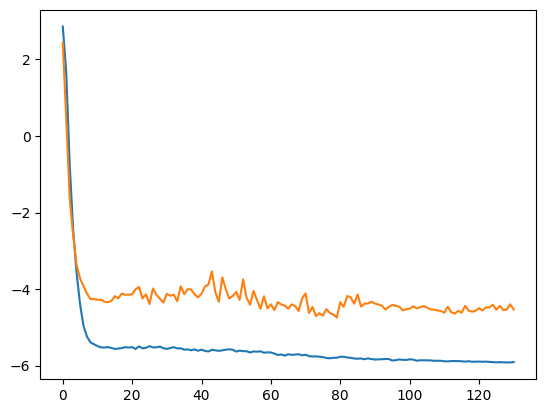

In [114]:
plt.plot(losses)
plt.show()

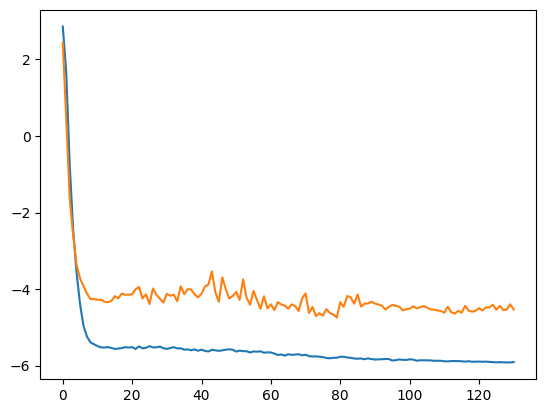

In [115]:
plt.plot(losses)
plt.show()

In [11]:
import gc
gc.collect()

2957

In [67]:
#w_trained = load_obj("/data103/makinen/des_results/patch_nets/net-B-log-add-extra/best_params.pkl")

In [89]:
w_trained = w

In [90]:
# define a function to obtain summaries from the embedding module
#appfn = lambda d: model.model.apply(w, x=d, rng=jr.PRNGKey(400), method='embedding')

def apply_embedding(input_data, w=w_trained):
    return model.model.apply(w, x=input_data, rng=jr.PRNGKey(400), method='embedding')

In [91]:
# now apply to the lfi dataset as in Josh's code

summaries_LFI = []
params_Tru_LFI = []

for i in tqdm(range(lfi_dataset.num_batch_per_epoch)):

    data = next(iter(lfi_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_LFI.append(theta_true)
    summaries_LFI.append(summs_out)


summaries_test = []
params_Tru_test = []

for i in tqdm(range(test_dataset.num_batch_per_epoch)):

    data = next(iter(test_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_test.append(theta_true)
    summaries_test.append(summs_out)


summaries_sys = []
params_Tru_sys = []

for i in tqdm(range(sys_dataset.num_batch_per_epoch)):

    data = next(iter(sys_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_sys.append(theta_true)
    summaries_sys.append(summs_out)


summaries_train = []
params_Tru_train = []

for i in tqdm(range(train_dataset.num_batch_per_epoch)):

    data = next(iter(train_dataset))

    X  = data['y']
    theta_true = data['theta']
    
    summs_out = apply_embedding(X)
    
    params_Tru_train.append(theta_true)
    summaries_train.append(summs_out)



summaries_LFI = np.concatenate(summaries_LFI, 0)
params_Tru_LFI = np.concatenate(params_Tru_LFI, 0)

summaries_test = np.concatenate(summaries_test, 0)
params_Tru_test = np.concatenate(params_Tru_test, 0)

summaries_sys = np.concatenate(summaries_sys, 0)
params_Tru_sys = np.concatenate(params_Tru_sys, 0)

summaries_train = np.concatenate(summaries_train, 0)
params_Tru_train = np.concatenate(params_Tru_train, 0)

100%|██████████| 193/193 [01:15<00:00,  2.54it/s]


In [102]:
np.savez("/home/makinen/repositories/des-hybrid/vanilla-comparison/summaries_patch_B_26_01_avg_extra",
         summaries_lfi=summaries_LFI,
         params_lfi=params_Tru_LFI,
         summaries_test=summaries_test,
         params_test=params_Tru_test,
         summaries_sys=summaries_sys,
         params_sys=params_Tru_sys,
         summaries_train=summaries_train,
         params_train=params_Tru_train
         )

In [25]:
params_Tru_LFI.shape

(3072, 3)

In [70]:
summaries_LFI = np.concatenate(summaries_LFI, 0)
params_Tru_LFI = np.concatenate(params_Tru_LFI, 0)

summaries_test = np.concatenate(summaries_test, 0)
params_Tru_test = np.concatenate(params_Tru_test, 0)

In [74]:
summaries_LFI.shape

(3072, 9)

In [78]:
summaries_LFI[0]

array([-0.2486794 , -0.79263544, -0.21065573,  0.08654279,  0.95726424,
       -2.4112587 ,  0.8326435 ,  1.2982042 ,  0.39099064], dtype=float32)

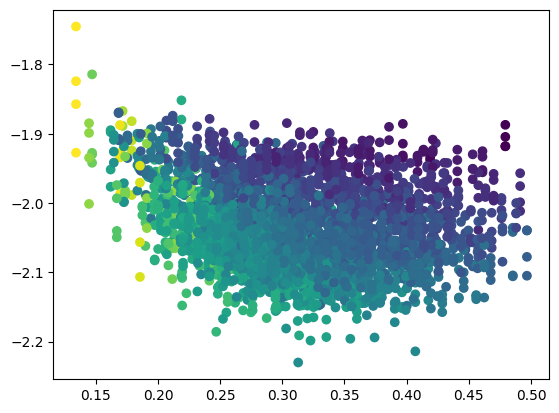

In [101]:
plt.scatter(params_Tru_LFI[:,0], summaries_LFI[:, -4], c=params_Tru_LFI[:, 1])
plt.show()
plt.close()

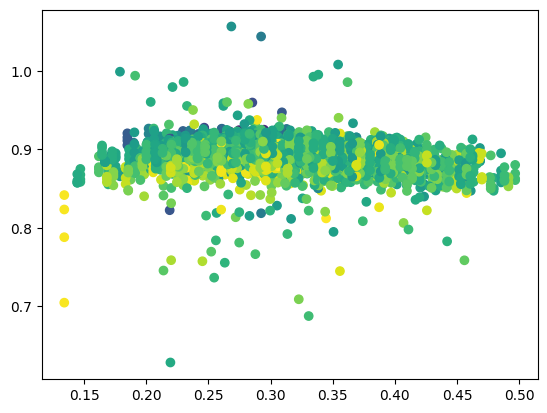

In [93]:
plt.scatter(params_Tru_LFI[:,0], summaries_LFI[:, -2], c=params_Tru_LFI[:, 2])
plt.show()
plt.close()

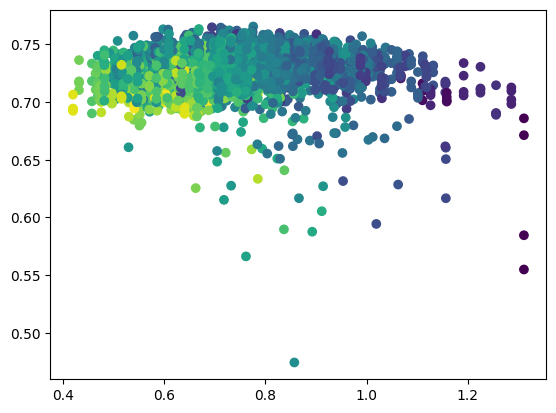

In [94]:
plt.scatter(params_Tru_LFI[:,1], summaries_LFI[:, -3], c=params_Tru_LFI[:, 0])
plt.show()
plt.close()